<a href="https://colab.research.google.com/github/PollyBecker/Convolucionais/blob/main/Redes_Neurais_Convolucionais_Classifica%C3%A7%C3%A3o_de_sinais_de_tr%C3%A2nsito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de sinais de trânsito com Arquitetura LeNet
A Arquitetura LeNet é composta por camadas de convolução, pooling e totalmente conectadas. A camada de convolução aplica filtros sobre a imagem de entrada para extrair características. A camada de pooling reduz o tamanho da imagem e aumenta a invariância a pequenas variações. A camada totalmente conectada recebe as características extraídas e realiza a classificação final.

- Arquitetura LeNet: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
- Arquitetura LeNet Wiki: https://en.wikipedia.org/wiki/LeNet
- Outros Artigos: https://en.wikipedia.org/wiki/LeNet

# Etapa 1: Importação das bibliotecas

In [2]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import zipfile
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

# Etapa 2: Importação da base de dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/traffic-signs-data.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [5]:
with open('/content/traffic-signs-data/train.p', mode='rb') as training_data:
  train = pickle.load(training_data)
with open('/content/traffic-signs-data/test.p', mode='rb') as testing_data:
  test = pickle.load(testing_data)
with open('/content/traffic-signs-data/valid.p', mode='rb') as validation_data:
  valid = pickle.load(validation_data)

In [6]:
train

{'coords': array([[  6,   5,  21,  20],
        [  6,   6,  22,  22],
        [  5,   6,  22,  23],
        ...,
        [ 17,  15, 178, 155],
        [ 17,  15, 183, 160],
        [ 20,  18, 211, 184]], dtype=uint8),
 'labels': array([41, 41, 41, ..., 25, 25, 25], dtype=uint8),
 'features': array([[[[ 28,  25,  24],
          [ 27,  24,  23],
          [ 27,  24,  22],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  25],
          [ 31,  27,  26]],
 
         [[ 29,  26,  25],
          [ 27,  25,  23],
          [ 27,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         [[ 28,  26,  26],
          [ 27,  25,  23],
          [ 26,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         ...,
 
         [[ 27,  24,  23],
          [ 28,  25,  24],
          [ 30,  25,  24],
          ...,
          [ 27,  24,  23],
          [ 28,  24,  22],
  

In [7]:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_validation, y_validation = valid['features'], valid['labels']

In [8]:
X_train.shape

(34799, 32, 32, 3)

In [9]:
y_train.shape

(34799,)

In [10]:
X_test.shape

(12630, 32, 32, 3)

In [11]:
X_validation.shape

(4410, 32, 32, 3)

# Etapa 3: Visualização dos dados

1

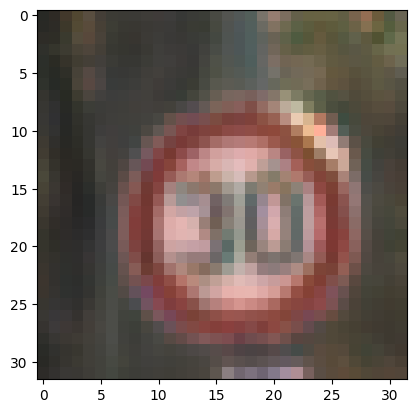

In [12]:
i = 3100
plt.imshow(X_train[i])
y_train[i]

36

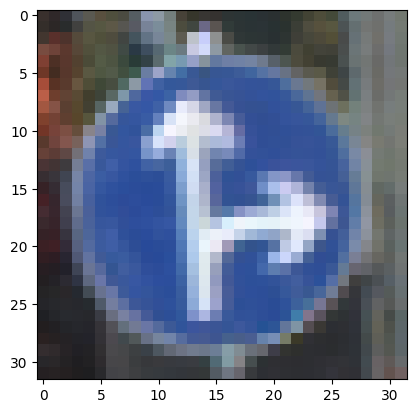

In [13]:
i = 3001
plt.imshow(X_test[i])
y_test[i]

8

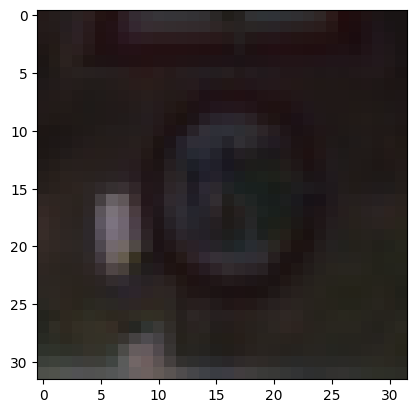

In [14]:
i = 2100
plt.imshow(X_validation[i])
y_validation[i]

# Etapa 4: Preparação dos dados
 Aqui vamos passar imagem para escala de cinza pois existem algumas vantagens em usar imagens em escala de cinza para esse tipo de tarefa:

- Redução de dimensão: Por exemplo, em imagens RGB, existem três canais de cores e tem três dimensões, enquanto as *imagens em escala de cinza são unidimensionais* e assim cupam menos espaço na memória e são mais fáceis de processar.
- Redução da complexidade do modelo: Treinar uma rede neural em imagens RGB de alta resolução exigiria uma rede muito grande e profunda, com muitos parâmetros e camadas, o que aumentaria o tempo e o custo de treinamento. Além disso, a rede poderia sofrer de overfitting, ou seja, aprender características específicas das imagens de treinamento que não generalizam bem para novas imagens. *Usando imagens em escala de cinza, podemos reduzir a complexidade do modelo e evitar esses problemas*.
- Extração de características relevantes: Dependendo do problema que queremos resolver, as cores das imagens podem não ser tão importantes quanto outras características, como formas, contornos, texturas, etc. Por exemplo, se queremos reconhecer dígitos manuscritos, a cor da tinta ou do papel não afeta a identificação do número. Nesse caso, usar imagens em escala de cinza pode ajudar a rede neural a focar nas características relevantes e ignorar as irrelevantes

In [15]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [16]:
X_train_gray = np.sum(X_train / 3, axis = 3, keepdims=True)
X_test_gray = np.sum(X_test / 3, axis = 3, keepdims=True)
X_validation_gray = np.sum(X_validation / 3, axis = 3, keepdims=True)

In [17]:
X_train_gray.shape

(34799, 32, 32, 1)

In [18]:
X_test_gray.shape

(12630, 32, 32, 1)

In [19]:
X_validation_gray.shape

(4410, 32, 32, 1)

In [23]:
X_train_gray_norm = (X_train_gray) / 255
X_test_gray_norm = (X_test_gray) / 255
X_validation_gray_norm = (X_validation_gray) / 255

In [24]:
np.max(X_train_gray_norm)

1.0

In [25]:
np.min(X_train_gray_norm)

0.014379084967320259

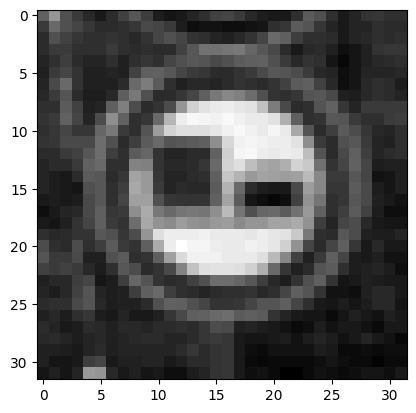

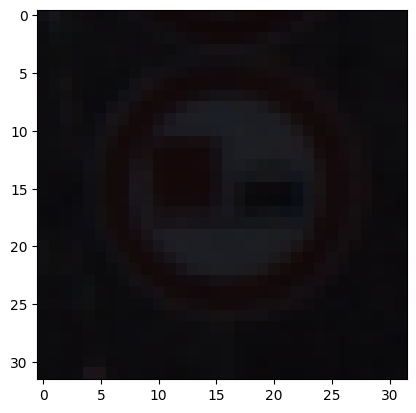

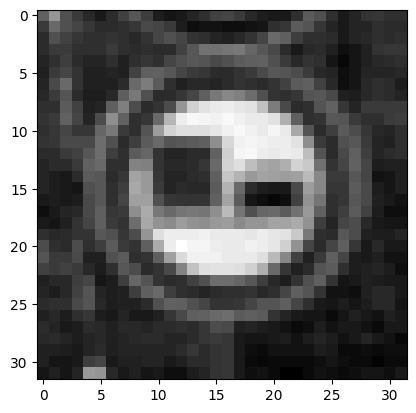

In [26]:
i = 60
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')

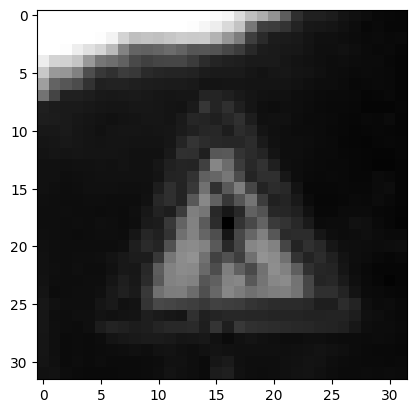

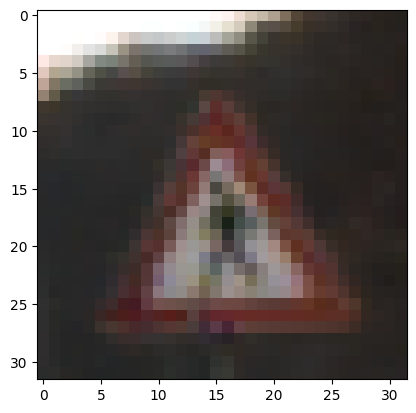

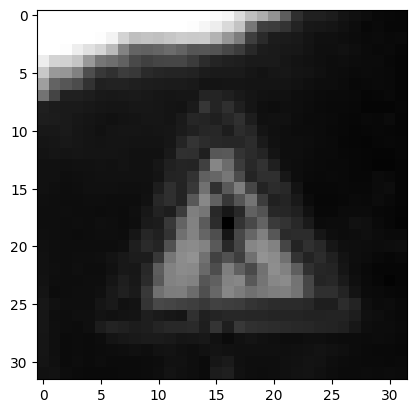

In [27]:
i = 610
plt.imshow(X_test_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_test[i])
plt.figure()
plt.imshow(X_test_gray_norm[i].squeeze(), cmap = 'gray')

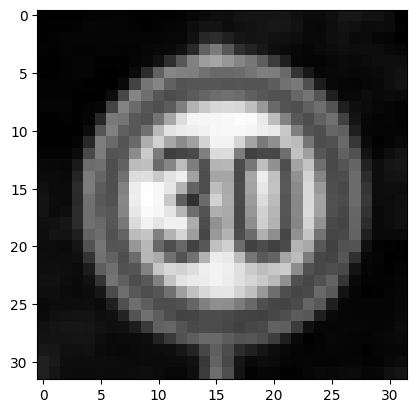

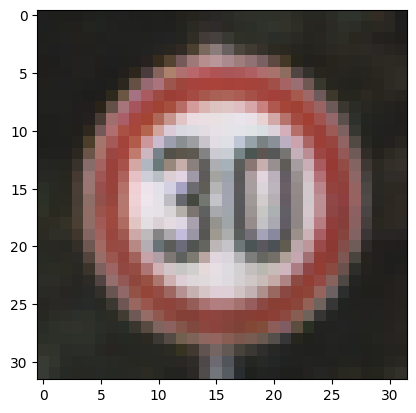

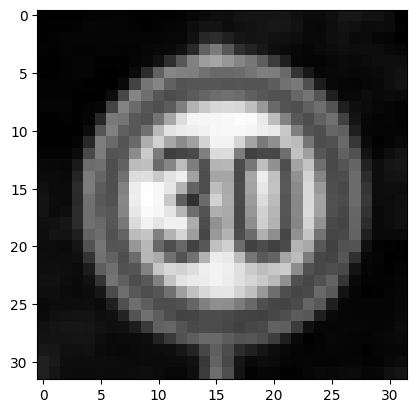

In [28]:
i = 500
plt.imshow(X_validation_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_validation[i])
plt.figure()
plt.imshow(X_validation_gray_norm[i].squeeze(), cmap = 'gray')

# Etapa 5: Criação do modelo e treinamento
Aqui usaremos o avarage poooling. A escolha entre max pooling e average pooling depende do problema que se quer resolver e do tipo de características que se quer extrair. Em geral, o max pooling é mais adequado para tarefas que exigem características específicas e distintas, como reconhecimento de objetos ou faces. O average pooling é mais adequado para tarefas que exigem características mais genéricas e suaves, como segmentação de imagens ou detecção de bordas.
- Artigo sobre uso do max e avarage pooling: https://iq.opengenus.org/maxpool-vs-avgpool/


Colinha da arquitetura

- STEP 1: THE FIRST CONVOLUTIONAL LAYER #1
    - Input = 32x32x1
    - Output = 28x28x6
    - Output = (Input-filter+1)/Stride* => (32-5+1)/1=28
    - Used a 5x5 Filter with input depth of 3 and output depth of 6
    - Apply a RELU Activation function to the output
    - pooling for input, Input = 28x28x6 and Output = 14x14x6

- STEP 2: THE SECOND CONVOLUTIONAL LAYER #2
    - Input = 14x14x6
    - Output = 10x10x16
    - Layer 2: Convolutional layer with Output = 10x10x16
    - Output = (Input-filter+1)/strides => 10 = 14-5+1/1
    - Apply a RELU Activation function to the output
    - Pooling with Input = 10x10x16 and Output = 5x5x16

- STEP 3: FLATTENING THE NETWORK
    - Flatten the network with Input = 5x5x16 and Output = 400

- STEP 4: FULLY CONNECTED LAYER
    - Layer 3: Fully Connected layer with Input = 400 and Output = 120
    - Apply a RELU Activation function to the output

- STEP 5: ANOTHER FULLY CONNECTED LAYER
    - Layer 4: Fully Connected Layer with Input = 120 and Output = 84
    - Apply a RELU Activation function to the output

- STEP 6: FULLY CONNECTED LAYER
    - Layer 5: Fully Connected layer with Input = 84 and Output = 43

In [29]:
from tensorflow.keras import layers, models

LeNet = models.Sequential()

LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32, 32, 1)))
LeNet.add(layers.AveragePooling2D())

LeNet.add(layers.Conv2D(16, (5,5), activation = 'relu'))
LeNet.add(layers.AveragePooling2D())

LeNet.add(layers.Flatten())

LeNet.add(layers.Dense(120, activation='relu'))

LeNet.add(layers.Dense(84, activation='relu'))

LeNet.add(layers.Dense(43, activation='softmax'))

LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

Antes nossas imagens tinham 32X32px o que gerava um total de 1024 pixels por imagem e como vemos na camada de flatten depois de todo pré processamento passamos apenas os 400px principais para nossa rede

In [30]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
history = LeNet.fit(X_train_gray_norm, y_train,
                    batch_size = 500,
                    epochs = 50,
                    validation_data = (X_validation_gray_norm, y_validation))

Epoch 1/50
70/70 [==============================] - 12s 18ms/step - loss: 3.2810 - accuracy: 0.1636 - val_loss: 2.7729 - val_accuracy: 0.3181
Epoch 2/50
70/70 [==============================] - 1s 9ms/step - loss: 1.9159 - accuracy: 0.4875 - val_loss: 1.7472 - val_accuracy: 0.5297
Epoch 3/50
70/70 [==============================] - 1s 9ms/step - loss: 1.2370 - accuracy: 0.6534 - val_loss: 1.2314 - val_accuracy: 0.6556
Epoch 4/50
70/70 [==============================] - 0s 7ms/step - loss: 0.9300 - accuracy: 0.7442 - val_loss: 1.0501 - val_accuracy: 0.7091
Epoch 5/50
70/70 [==============================] - 0s 7ms/step - loss: 0.7538 - accuracy: 0.7944 - val_loss: 0.8895 - val_accuracy: 0.7587
Epoch 6/50
70/70 [==============================] - 0s 7ms/step - loss: 0.6240 - accuracy: 0.8307 - val_loss: 0.8523 - val_accuracy: 0.7785
Epoch 7/50
70/70 [==============================] - 1s 8ms/step - loss: 0.5376 - accuracy: 0.8552 - val_loss: 0.7491 - val_accuracy: 0.8032
Epoch 8/50
70/70 [

# Etapa 6: Avaliação do modelo

In [32]:
score = LeNet.evaluate(X_test_gray_norm, y_test)
print('Test Accuracy: {}'.format(score[1]))

395/395 [==============================] - 1s 3ms/step - loss: 1.2311 - accuracy: 0.8593
Test Accuracy: 0.8593032360076904


In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
val_accuracy

[0.31814059615135193,
 0.5297052264213562,
 0.6555555462837219,
 0.7090702652931213,
 0.7587301731109619,
 0.7784580588340759,
 0.803174614906311,
 0.8287981748580933,
 0.8310657739639282,
 0.821541965007782,
 0.8317460417747498,
 0.8403627872467041,
 0.8446711897850037,
 0.8494331240653992,
 0.8575963973999023,
 0.8539682626724243,
 0.8510203957557678,
 0.8523809313774109,
 0.8637188076972961,
 0.8578231334686279,
 0.8462585210800171,
 0.8560090661048889,
 0.8684807419776917,
 0.844897985458374,
 0.8544217944145203,
 0.8594104051589966,
 0.8619047403335571,
 0.8562358021736145,
 0.8539682626724243,
 0.8630385398864746,
 0.8494331240653992,
 0.8503401279449463,
 0.8596372008323669,
 0.8634920716285706,
 0.8709750771522522,
 0.8648526072502136,
 0.8546485304832458,
 0.8557823300361633,
 0.8736961483955383,
 0.8623582720756531,
 0.8650793433189392,
 0.8687074780464172,
 0.858730137348175,
 0.86099773645401,
 0.8600907325744629,
 0.8643990755081177,
 0.8673469424247742,
 0.859410405158996

<ipython-input-36-46d7eff3f114>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'bo', color = 'r', label='Training Accuracy')


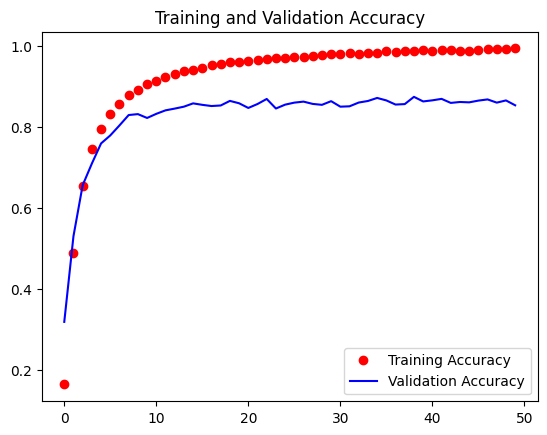

In [36]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', color = 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

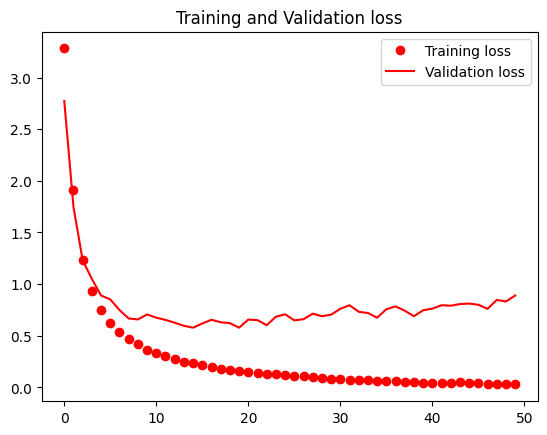

In [37]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend();

Podemos treinar apenas até a 15 época que está ótimo. Depois disso o loss começa a aumentar.

In [38]:
#predicted_classes = LeNet.predict_classes(X_test_gray_norm) -- Atualizado 17/01/22
#y_true = y_test

In [39]:
predict_x = LeNet.predict(X_test_gray_norm)
predicted_classes=np.argmax(predict_x,axis=1)
y_true = y_test

395/395 [==============================] - 1s 2ms/step


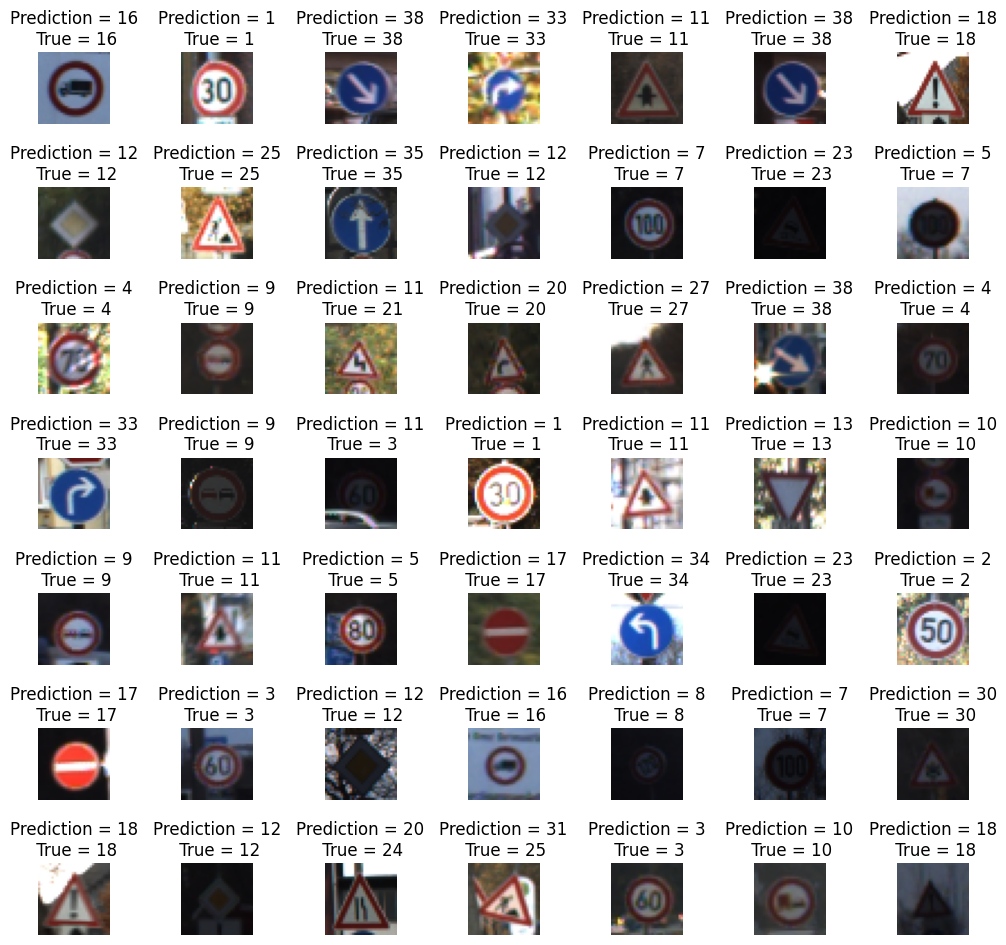

In [40]:
L = 7
W = 7

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)